# MHBF Project: Reinforcement Learning

Johannes Rieke and Alexander Moore

In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

## Create environment

In [11]:
class Environment():
    
    maze = mpl.path.Path([(5, 0), (5, 50), (55, 50), (55, 60), (-55, 60), (-55, 50), (-5, 50), (-5, 0), (5, 0)])
    pickup_area = mpl.path.Path([(35, 50), (55, 50), (55, 60), (35, 60), (35, 50)])
    target_area = mpl.path.Path([(-55, 50), (-35, 50), (-35, 60), (-55, 60), (-55, 50)])
    
    def __init__(self):
        self.reset()
        
    def _state(self):
        return (self.x, self.y, self.picked_up)
    
    def reset(self):
        self.x = 0
        self.y = 0
        self.picked_up = False
        return self._state()
        
    def step(self, angle):
        distance = np.random.normal(3, 1.5)
        self.x += distance * np.sin(angle)
        self.y += distance * np.cos(angle)
        
        reward = 0
        done = False
        
        if not self.maze.contains_point((self.x, self.y)):
            reward = -1
            # Move back in small steps.
            while not self.maze.contains_point((self.x, self.y)):
                self.x -= 0.1 * distance * np.sin(angle)
                self.y -= 0.1 * distance * np.cos(angle)
                
        if self.pickup_area.contains_point((self.x, self.y)):
            self.picked_up = True
            
        if self.target_area.contains_point((self.x, self.y)) and self.picked_up:
            reward = 20
            done = True
            
        return self._state(), reward, done
    
    def plot(self):
        plt.gca().add_patch(mpl.patches.PathPatch(env.maze, fc='none'))
        plt.gca().add_patch(mpl.patches.PathPatch(env.pickup_area, fc='blue', ec='none', alpha=0.2))
        plt.gca().add_patch(mpl.patches.PathPatch(env.target_area, fc='red', ec='none', alpha=0.2))
        plt.xlim(-60, 60)
        plt.ylim(-5, 65)
        plt.axis('off')

In [12]:
def plot_trajectory(xs, ys):
    plt.plot(xs, ys, 'k', alpha=0.4)
    plt.scatter(xs, ys, c=range(len(xs)), cmap='cool', s=10)

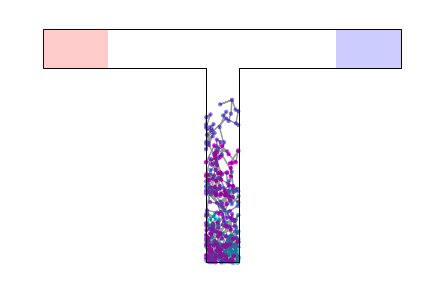

In [13]:
# Random walk in the maze (just to test the visualization).
plt.figure(figsize=(7, 5))

num_steps = 500
xs, ys = np.zeros(num_steps), np.zeros(num_steps)

env = Environment()
xs[0], ys[0], _ = env.reset()

for i in range(1, num_steps):
    (xs[i], ys[i], _), reward, done = env.step(np.random.rand() * 2 * np.pi)
    
env.plot()
plot_trajectory(xs, ys)

## Distribute place fields across the environment

In [14]:
# Find coordinates of the place field centers.
place_field_centers = []

# Create an eqully spaced meshgrid across the coordinate system, 
# then filter the points that are inside the maze. 
xx, yy = np.meshgrid(np.arange(-52.5, 53, 5), np.arange(2.5, 60, 5))
for x, y in zip(xx.flatten(), yy.flatten()):
    if env.maze.contains_point((x, y)):
        place_field_centers.append((x, y))

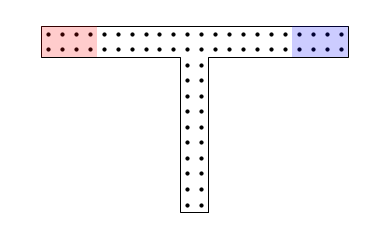

In [15]:
env.plot()
plt.scatter(*np.array(place_field_centers).T, c='k', s=10)

## Calculate activities of the network

In [65]:
class NeuralNetwork():
    
    def __init__(self, place_field_centers, num_actions, sigma=5):
        self.place_field_centers = place_field_centers
        self.weights = np.random.rand(num_actions, len(place_field_centers)*2)
        self.sigma = sigma
        
    def input_activity(self, state):
        activity_all_neurons = np.zeros(len(self.place_field_centers)*2)
        x, y, picked_up = state

        if picked_up:  # write activations into left half of the neurons
            activity_active_population = activity_all_neurons[len(self.place_field_centers):]  
        else:  # write activation into the right half of the neurons
            activity_active_population = activity_all_neurons[:len(self.place_field_centers)]  

        for i, (x_i, y_i) in enumerate(self.place_field_centers):
            activity_active_population[i] = np.exp(-((x_i - x)**2 + (y_i - y)**2) / (2 * self.sigma**2))

        return activity_all_neurons
    
    def output_activity(self, state=None, input_activity=None):
        if input_activity is None:
            input_activity = self.input_activity(state)
        return np.dot(self.weights, input_activity)

In [66]:
nn = NeuralNetwork(place_field_centers, 4)

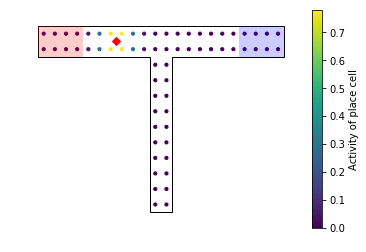

In [67]:
env.plot()

x = -20
y = 55
plt.plot(x, y, 'rD')

activity = nn.input_activity([x, y, False])[:len(place_field_centers)]
plt.scatter(*np.array(place_field_centers).T, c=activity, s=10)
plt.colorbar(label='Activity of place cell')

In [68]:
nn.output_activity(input_activity=input_activity([0, 0, False]))

array([ 1.28531451,  0.76895676,  0.48618691,  1.74056151])

In [69]:
nn.output_activity(state=[0, 0, False])

array([ 1.28531451,  0.76895676,  0.48618691,  1.74056151])

In [70]:
def choose_action(Q, epsilon):
    if np.random.rand() < epsilon:  # choose random action
        angle = np.random.randint(num_actions) / num_actions * 2 * np.pi
    else:  # choose best action
        angle = np.argmax(Q) / num_actions * 2 * np.pi
    return angle

## Set parameters and train

In [72]:
learning_rate = 0.1
gamma = 0.95
decay_rate = 0.5
num_trials = 12

# Decay epsilon from 1 to 0.1 during the first 800 trials and keep it at 0.1 for the next 200 trials
epsilon_per_trial = np.zeros(num_trials)
#epsilon_per_trial[:800] = np.linspace(1, 0.1, 800)
#epsilon_per_trial[800:] = 0.1
epsilon_per_trial[:] = 1

num_steps_per_trial = []
xs_per_trial = []
ys_per_trial = []



# TODO: Run this for 10 different instances of NeuralNetwork and average results across them.

for trial, epsilon in enumerate(epsilon_per_trial):
    
    xs = []
    ys = []
    
    state = env.reset()
    xs.append(state[0])
    ys.append(state[1])
    done = False
    step = 0

    Q = nn.output_activity(state)
    action = choose_action(Q, epsilon)

    while not done:
        step += 1
        
        #print(step, state, action)

        next_state, reward, done = env.step(action)

        Q_next = nn.output_activity(next_state)
        next_action = choose_action(Q_next, epsilon)

        # TODO: Perform SARSA update of weights based on Q, Q_next, reward.

        state, action = next_state, next_action
        xs.append(state[0])
        ys.append(state[1])
    
    num_steps_per_trial.append(step)
    xs_per_trial.append(xs)
    ys_per_trial.append(ys)

## Visualize results

### Trajectories for several trials

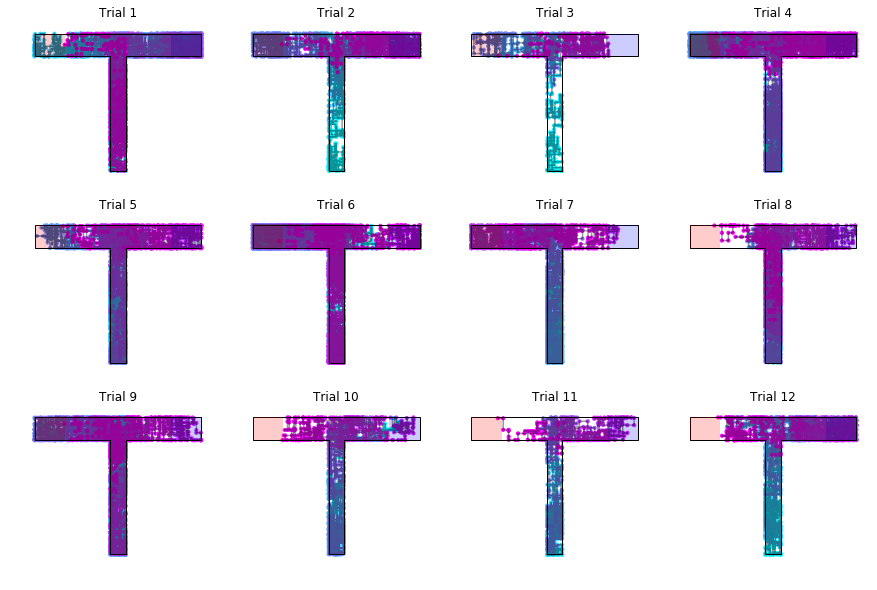

In [73]:
fig, axes = plt.subplots(3, 4, figsize=(15, 10))

for trial, ax in enumerate(axes.flatten()):
    plt.sca(ax)
    env.plot()
    plot_trajectory(xs_per_trial[trial], ys_per_trial[trial])
    plt.title('Trial {}'.format(trial+1))

### Learning curve

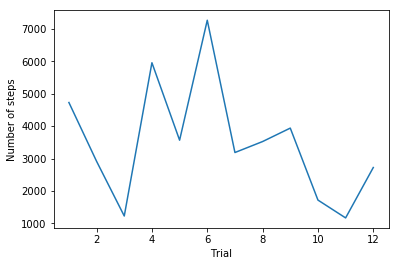

In [74]:
plt.plot(range(1, num_trials+1), num_steps_per_trial)
plt.xlabel('Trial')
plt.ylabel('Number of steps')